# Customer Churn Prediction

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

#### Data Preparation based on EDA

In [ ]:
def datapreprocess(filepath):

    df = pd.read_csv(filepath)
    df.drop(["CustomerId"], inplace = True, axis = 1)
    df.drop(["Surname"], inplace = True, axis = 1)
    df.drop(["Geography"], inplace = True, axis = 1)
    df.Gender = df.Gender.apply(lambda x: 0 if x == "Male" else 1)
    return df

In [ ]:
df = datapreprocess(filepath = '/content/Churn_Modelling.csv')
df.head()
print(df.columns)

Index(['RowNumber', 'CreditScore', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Churn'],
      dtype='object')


In [ ]:
df.isnull().any().any()

False

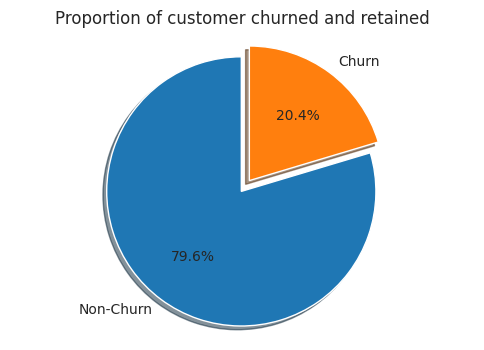

In [ ]:
labels = 'Non-Churn', 'Churn'
sizes = [df.Churn[df['Churn']==0].count(), df.Churn[df['Churn']==1].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(6, 4))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained")
plt.show();

## Model Building

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=111, stratify = df.Churn)

In [ ]:
x = df.columns[df.columns!="Churn"]
y = "Churn"
train_x = train[x]
train_y = train[y]
test_x = test[x]
test_y = test[y]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
X_train = tf.convert_to_tensor(train_x, dtype=tf.float32)
X_val = tf.convert_to_tensor(test_x, dtype=tf.float32)
y_train = tf.convert_to_tensor(train_y, dtype=tf.float32)
y_val = tf.convert_to_tensor(test_y, dtype=tf.float32)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to your training data
scaler.fit(X_train)

# Transform the training and validation data
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

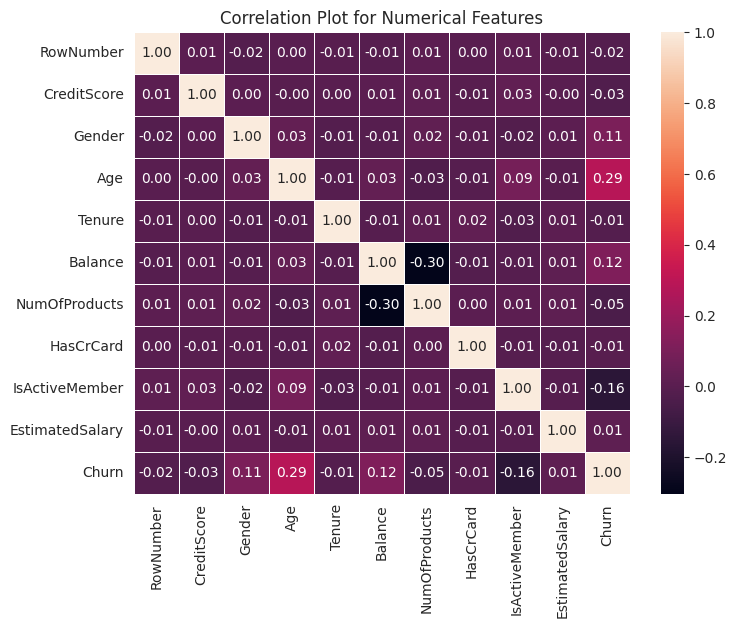

In [ ]:
# Filter out only numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix for numerical features
corr_matrix = numerical_features.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Plot for Numerical Features')
plt.show()

In [ ]:
input = 10
output_units = 1 # binary classification
# Define the neural network model
model = Sequential()

# Add the input layer and first hidden layer with tanh activation and dropout
model.add(Dense(units = 32, activation='tanh', input_shape=(input,)))
model.add(Dropout(rate=0.3))

# Add the second hidden layer with ReLU activation
model.add(Dense(units = 64, activation='relu'))

# Add the third hidden layer with ReLU activation
model.add(Dense(units = 32, activation='relu'))

# Add the output layer with sigmoid activation
model.add(Dense(units = output_units, activation='sigmoid'))

# Compile the model with ADAM optimizer, binary cross-entropy loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000474718),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_val_scaled, y_val))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                352       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4577 (17.88 KB)
Trainable params: 4577 (17.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
250/250 [=

In [ ]:
loss, accuracy = model.evaluate(X_val_scaled, y_val)

# Print the evaluation results
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

63/63 [==============================] - 0s 4ms/step - loss: 0.3536 - accuracy: 0.8535
Validation Loss: 0.3535533547401428
Validation Accuracy: 0.8535000085830688


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Make predictions on the validation data
y_pred = model.predict(X_val_scaled)

# Convert probabilities to class labels
y_pred_labels = (y_pred > 0.5).astype(int)

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred_labels))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_labels))

# ROC AUC Score
roc_auc = roc_auc_score(y_val, y_pred)
print("ROC AUC Score:", roc_auc)


63/63 [==============================] - 1s 8ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91      1593
         1.0       0.73      0.44      0.55       407

    accuracy                           0.85      2000
   macro avg       0.80      0.70      0.73      2000
weighted avg       0.84      0.85      0.84      2000

Confusion Matrix:
[[1528   65]
 [ 228  179]]
ROC AUC Score: 0.8525011914842422


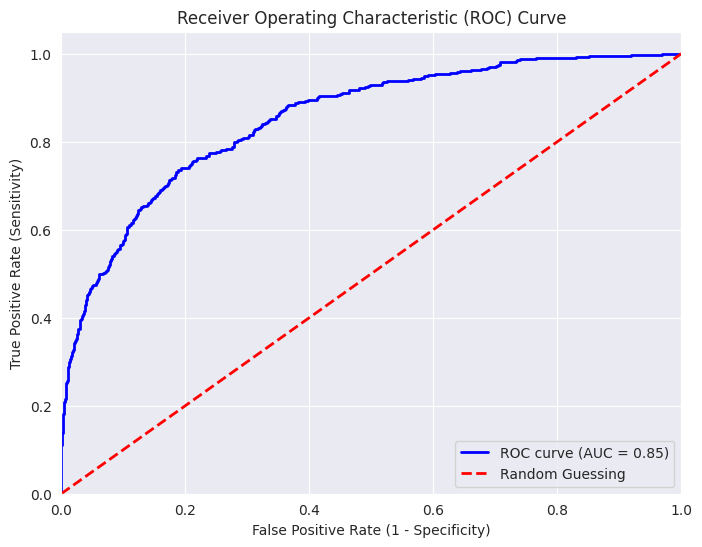

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

RANDOM FOREST

In [ ]:
#function for model fitting
def churn_prediction(algo, training_x, training_y, testing_x, testing_y, cols, cf = 'coefficients'):
    algo.fit(training_x,training_y)
    predictions = algo.predict(testing_x)
    probabilities = algo.predict_proba(testing_x)[:,1]

    #coeffs
    if cf == "coefficients":
        coefficients = pd.DataFrame(algo.coef_.ravel())
    elif cf == "features":
        coefficients = pd.DataFrame(algo.feature_importances_)

    column_df = pd.DataFrame(cols)
    coef_sumry = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry = coef_sumry.sort_values(by = "coefficients",ascending = False)

    print (algo)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))

    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,probabilities)
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities)

    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    plt.subplot(212)
    sns.barplot(x = coef_sumry["features"] ,y = coef_sumry["coefficients"])
    plt.title('Feature Importances')
    plt.xticks(rotation="vertical")

    plt.show()

### Hyperparameters Tuning

#### Grid 1: Selecting class weight and estimators

In [ ]:
param_grid1 = {'max_features':['auto', 'sqrt', 'log2', None],
          'n_estimators':[300, 500, 700, 900, 1100, 1300]
         }

rf_model = RandomForestClassifier()
grid1 = GridSearchCV(estimator=rf_model, param_grid=param_grid1, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid1.fit(X_train_scaled, train_y)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2', None],
                         'n_estimators': [300, 500, 700, 900, 1100, 1300]},
             scoring='f1', verbose=1)

In [ ]:
grid1.best_estimator_

RandomForestClassifier(max_features='log2', n_estimators=500)

<Axes: xlabel='param_max_features', ylabel='param_n_estimators'>

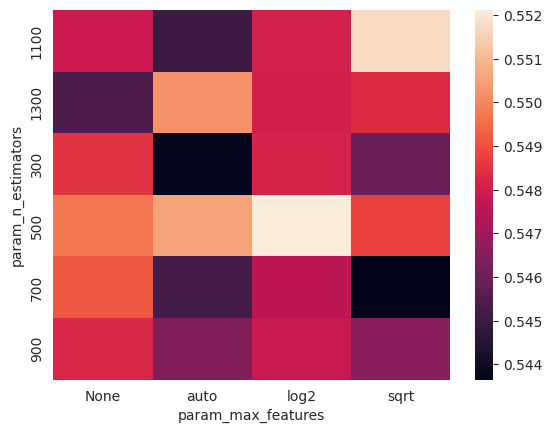

In [ ]:
dt = pd.DataFrame(grid1.cv_results_)
dt.param_max_features = dt.param_max_features.astype(str)
dt.param_n_estimators = dt.param_n_estimators.astype(str)

table = pd.pivot_table(dt, values='mean_test_score', index='param_n_estimators',
                       columns='param_max_features')

sns.heatmap(table)

In [ ]:
grid1.best_score_

0.5521185903333915

#### Grid 2: Selecting max depth and split criterion

In [ ]:
param_grid2 = {'max_features':['auto'],
          'n_estimators':[1000, 1100, 1200],
           'criterion': ['entropy', 'gini'],
          'max_depth': [7, 9, 11, 13, 15, None],
         }

rf_model = RandomForestClassifier()
grid2 = GridSearchCV(estimator=rf_model, param_grid=param_grid2, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid2.fit(X_train_scaled, train_y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [7, 9, 11, 13, 15, None],
                         'max_features': ['auto'],
                         'n_estimators': [1000, 1100, 1200]},
             scoring='f1', verbose=1)

In [ ]:
grid2.best_estimator_

RandomForestClassifier(max_features='auto', n_estimators=1200)

<Axes: xlabel='param_criterion', ylabel='param_max_depth'>

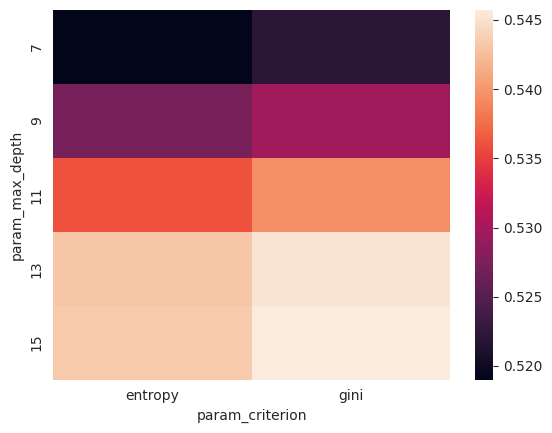

In [ ]:
dt = pd.DataFrame(grid2.cv_results_)

table = pd.pivot_table(dt, values='mean_test_score', index='param_max_depth',
                       columns='param_criterion')

sns.heatmap(table)

<Axes: xlabel='param_n_estimators', ylabel='param_max_depth'>

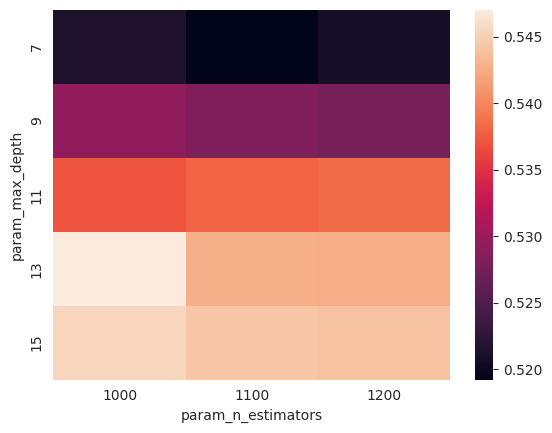

In [ ]:
table = pd.pivot_table(dt, values='mean_test_score', index='param_max_depth',
                       columns='param_n_estimators')

sns.heatmap(table)

In [ ]:
grid2.best_score_

0.5476929953564924

Checking if other depth and estimator value results better

In [ ]:
param_grid2_2 = {'max_features':['auto'],
          'n_estimators':[950, 1000, 1050],
           'criterion': ['entropy'],
          'max_depth': [10, 11, 12],
         }

rf_model = RandomForestClassifier()
grid2_2 = GridSearchCV(estimator=rf_model, param_grid=param_grid2_2, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid2_2.fit(train_x, train_y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [10, 11, 12],
                         'max_features': ['auto'],
                         'n_estimators': [950, 1000, 1050]},
             scoring='f1', verbose=1)

In [ ]:
grid2_2.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=12, max_features='auto',
                       n_estimators=950)

In [ ]:
grid2_2.best_score_

0.54416508277515

#### Grid 3: Selecting minimum samples leaf and split

In [ ]:
param_grid3 = {'max_features':['auto'],
          'n_estimators':[1000],
           'criterion': ['entropy'],
          'max_depth': [10],
          'min_samples_leaf': [1, 3, 5, 7],
          'min_samples_split': [2, 4, 6, 8]
         }

rf_model = RandomForestClassifier()
grid3 = GridSearchCV(estimator=rf_model, param_grid=param_grid3, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid3.fit(train_x, train_y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [10],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [1000]},
             scoring='f1', verbose=1)

In [ ]:
grid3.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='auto',
                       min_samples_leaf=5, min_samples_split=8,
                       n_estimators=1000)

<Axes: xlabel='param_min_samples_split', ylabel='param_min_samples_leaf'>

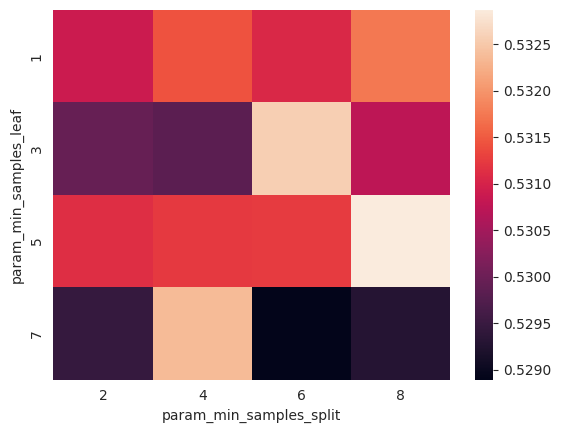

In [ ]:
dt = pd.DataFrame(grid3.cv_results_)

table = pd.pivot_table(dt, values='mean_test_score', index='param_min_samples_leaf',
                       columns='param_min_samples_split')

sns.heatmap(table)

In [ ]:
grid3.best_score_

0.5328702107123758

#### Grid 4: Selecting class weight

In [ ]:
param_grid4 = {'class_weight':[{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}],
            'max_features':['auto'],
          'n_estimators':[1000],
           'criterion': ['entropy'],
          'max_depth': [10],
          'min_samples_leaf': [1],
          'min_samples_split': [8]
         }

rf_model = RandomForestClassifier()
grid4 = GridSearchCV(estimator=rf_model, param_grid=param_grid4, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid4.fit(train_x, train_y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}],
                         'criterion': ['entropy'], 'max_depth': [10],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [8], 'n_estimators': [1000]},
             scoring='f1', verbose=1)

In [ ]:
grid4.best_estimator_

RandomForestClassifier(class_weight={0: 1, 1: 3}, criterion='entropy',
                       max_depth=10, max_features='auto', min_samples_split=8,
                       n_estimators=1000)

<Axes: ylabel='param_class_weight'>

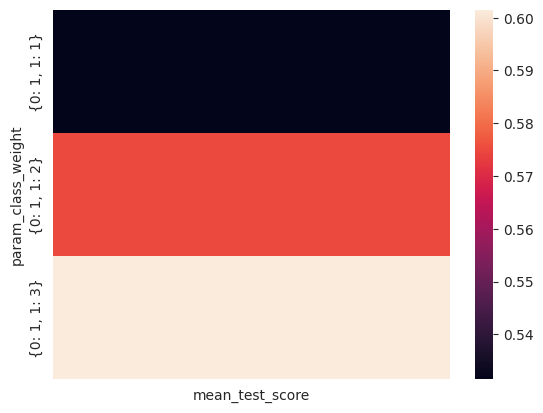

In [ ]:
dt = pd.DataFrame(grid4.cv_results_)
dt.param_class_weight = dt.param_class_weight.astype(str)
table = pd.pivot_table(dt, values='mean_test_score', index='param_class_weight')

sns.heatmap(table)

In [ ]:
grid4.best_score_

0.6015181321160971

### Final Model

In [ ]:
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 3},
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(class_weight={0: 1, 1: 2}, criterion='entropy',
                       max_depth=10, max_features='auto', min_samples_split=8,
                       n_estimators=1000)

 Classification report : 
               precision    recall  f1-score   support

           0       0.88      0.93      0.91      1593
           1       0.65      0.52      0.58       407

    accuracy                           0.85      2000
   macro avg       0.77      0.73      0.74      2000
weighted avg       0.84      0.85      0.84      2000

Accuracy   Score :  0.8455
Area under curve :  0.8522883438137675 



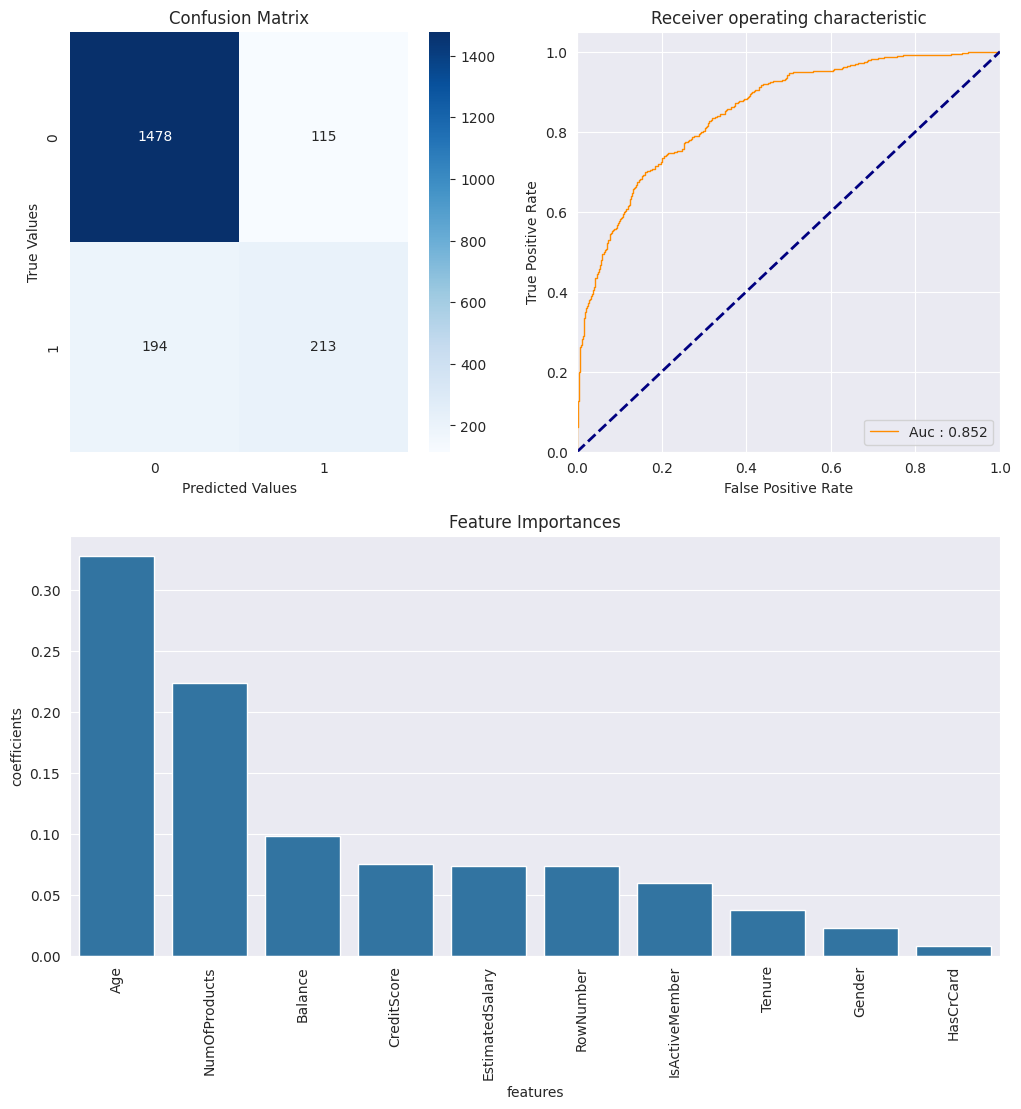

In [ ]:
churn_prediction(model, train_x, train_y, test_x, test_y, x,"features")

Checking the model's performance

In [ ]:
train_scores = cross_val_score(model, train_x, train_y, cv = 5, scoring='f1')
train_scores

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

array([0.60273973, 0.6       , 0.57777778, 0.59507042, 0.52823315])

In [ ]:
np.mean(train_scores)

0.5807642155048713

As we can see that the performance of the model on test data is same as training data. So, we can conclude that there is no overfitting and underfitting.

XGBOOST

In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier()

# Fit the model on the training data
model.fit(train_x, train_y)

# Make predictions on the test data
predictions = model.predict(test_x)

# Evaluate the model
accuracy = accuracy_score(test_y, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8405


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.1 MB/s eta 0:00:00


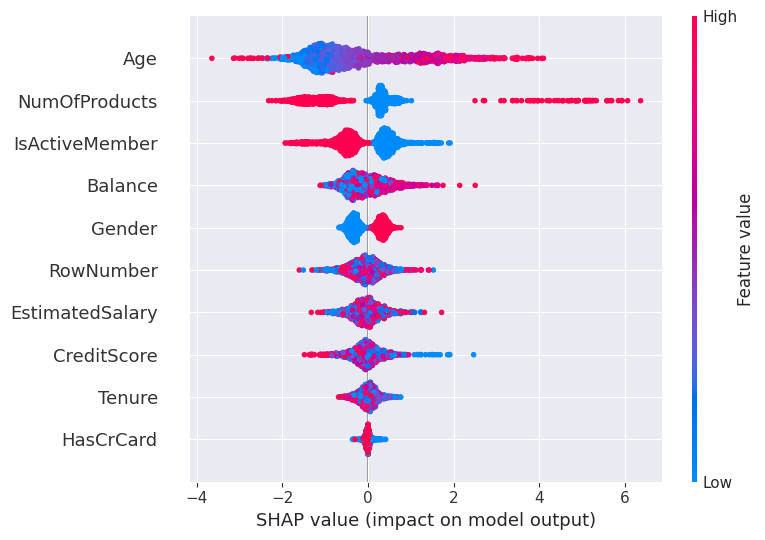

In [ ]:
import shap

# Explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(test_x)

# Summary plot: Feature importances
shap.summary_plot(shap_values, test_x)

# Individual prediction explanation plot (replace 0 with the index of the prediction you want to explain)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], test_x.iloc[0,:])